# How to use Tempered SMC to improve exploration of MCMC methods.
Multimodal distributions are typically hard to sample from, in particular using energy based methods such as HMC,
as you need high energy levels to escape a potential well. Tempered SMC helps with this by considering a sequence of
distributions $p_{\lambda_k}(x) \propto p_0(x) \exp(-\lambda_k V(x))$ where the tempering parameter $\lambda_k$ takes increasing values between $0$ and $1$. Tempered SMC will also particularly shine when the MCMC step 
is not well calibrated (too small step size, etc) like in the example below.

## Imports


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal

from blackjax.hmc import kernel as hmc_kernel
from blackjax.hmc import new_state as hmc_state
from blackjax.inference.smc.resampling import systematic
from blackjax.nuts import kernel as nuts_kernel
from blackjax.nuts import new_state as nuts_state
from blackjax.tempered_smc import TemperedSMCState, adaptive_tempered_smc

## Experimental setup
We consider a prior distribution $p_0(x) = \mathcal{N}(x \mid 0_2, I_2)$ and a potential function $V(x) = (||x||^2 - 1)^2$
This corresponds to the following distribution. We plot the resulting tempered density for 5 different values of $\lambda_k$: from $\lambda_k =1$ which correponds to the original density to $\lambda_k=0$. The lower the value of $\lambda_k$ the easier it is to sampler from the posterior density.

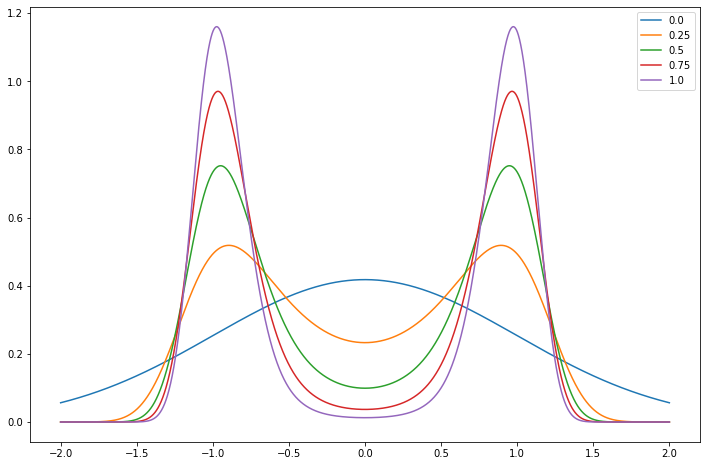

In [2]:
def V(x):
    return 5 * jnp.square(jnp.sum(x ** 2) - 1)


def prior_log_prob(x):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d))


linspace = jnp.linspace(-2, 2, 5000).reshape(-1, 1)
lambdas = jnp.linspace(0.0, 1.0, 5)
prior_logvals = jnp.vectorize(prior_log_prob, signature="(d)->()")(linspace)
potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)
log_res = prior_logvals.reshape(1, -1) - jnp.expand_dims(
    lambdas, 1
) * potential_vals.reshape(1, -1)

density = jnp.exp(log_res)
normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (
    linspace[1] - linspace[0]
)
density /= normalizing_factor

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(linspace.squeeze(), density.T)
ax.legend(list(lambdas))

In [3]:
def inference_loop(rng_key, mcmc_kernel, initial_state, num_samples):
    def one_step(state, k):
        state, _ = mcmc_kernel(k, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


def full_potential(x):
    return V(x) - prior_log_prob(x)


inv_mass_matrix = jnp.eye(1)
n_samples = 10_000

## HMC sampler

We first try to sample from the posterior density using an HMC kernel.

CPU times: user 1.9 s, sys: 39.6 ms, total: 1.94 s
Wall time: 1.93 s


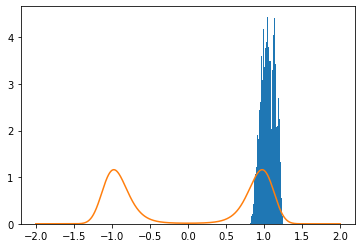

In [4]:
%%time

key = jax.random.PRNGKey(42)

hmc_params = dict(
    step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=50
)

hmc_kernel_instance = jax.jit(hmc_kernel(full_potential, **hmc_params))
initial_hmc_state = hmc_state(jnp.ones((1,)), full_potential)
hmc_samples = inference_loop(key, hmc_kernel_instance, initial_hmc_state, n_samples)

_ = plt.hist(hmc_samples.position[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

## NUTS sampler

We do the same using a NUTS kernel.

CPU times: user 9.78 s, sys: 556 µs, total: 9.78 s
Wall time: 9.81 s


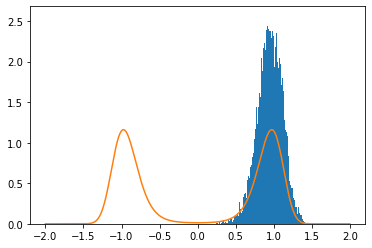

In [5]:
%%time

nuts_params = dict(step_size=1e-4, inverse_mass_matrix=inv_mass_matrix)

nuts_kernel_instance = jax.jit(nuts_kernel(full_potential, **nuts_params))
initial_nuts_state = nuts_state(jnp.ones((1,)), full_potential)
nuts_samples = inference_loop(key, nuts_kernel_instance, initial_nuts_state, n_samples)

_ = plt.hist(nuts_samples.position[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

## Tempered SMC with HMC kernel

We now use the adaptive tempered SMC algorithm with an HMC kernel. We only take one HMC step before resampling. The algorithm is run until $\lambda_k$ crosses the $\lambda_k = 1$ limit.

Number of steps in the adaptive algorithm:  2
CPU times: user 3.8 s, sys: 612 ms, total: 4.42 s
Wall time: 3.66 s


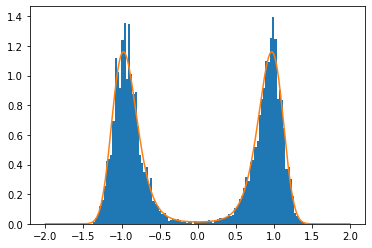

In [6]:
%%time

hmc_factory_params = dict(
    step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=1
)
mcmc_kernel_factory = lambda pot_fun: hmc_kernel(pot_fun, **hmc_factory_params)
smc_kernel_instance = jax.jit(
    adaptive_tempered_smc(
        prior_log_prob, V, mcmc_kernel_factory, hmc_state, systematic, 0.5, mcmc_iter=1
    )
)
initial_smc_state = jax.random.multivariate_normal(
    jax.random.PRNGKey(0), jnp.zeros([1]), jnp.eye(1), (n_samples,)
)
initial_smc_state = TemperedSMCState(initial_smc_state, 0.0)


def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the temepered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, _k = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, k = carry
        k, subk = jax.random.split(k, 2)
        state, _ = smc_kernel(subk, state)
        return i + 1, state, k

    n_iter, final_state, _ = jax.lax.while_loop(
        cond, one_step, (0, initial_state, rng_key)
    )

    return n_iter, final_state


n_iter, smc_samples = smc_inference_loop(key, smc_kernel_instance, initial_smc_state)
print("Number of steps in the adaptive algorithm: ", n_iter.item())
_ = plt.hist(smc_samples.particles[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

The tempered SMC algorithm with the HMC kernel clearly outperfoms the HMC and NUTS kernels alone, while being faster than the NUTS kernel alone.